# **Bootstrap**

|                |   |
:----------------|---|
| **Name**     | Eddie Aguilar  |
| **Date**      | 04/10/2025  |
| **ID** | 739352  | 

## Normal linear regression

In [59]:
import pandas as pd 
import statsmodels.api as sm
import numpy as np

data = pd.read_excel(r"C:\Users\AgJo413\Documents\GitHub\Lab_std\labstds\Data\Motor Trend Car Road Tests.xlsx")
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [60]:
X = data["hp"].to_frame()
y = data["mpg"].to_frame()

In [61]:

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

b0, b1 = model.params
se_b0, se_b1 = model.bse
ci = model.conf_int()

print(f"b0 (intercept): {b0:.4f}, SE: {se_b0:.4f}, 95% CI: {tuple([ci[0][0], ci[1][0]])}")
print(f"b1 (slope):     {b1:.4f}, SE: {se_b1:.4f}, 95% CI: {tuple([ci[0][1], ci[1][1]])}")


b0 (intercept): 30.0989, SE: 1.6339, 95% CI: (26.761948787045345, 33.43577229219968)
b1 (slope):     -0.0682, SE: 0.0101, 95% CI: (-0.08889465352053424, -0.0475619026225931)


C:\Users\AgJo413\AppData\Local\Temp\ipykernel_21748\4026295705.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"b0 (intercept): {b0:.4f}, SE: {se_b0:.4f}, 95% CI: {tuple([ci[0][0], ci[1][0]])}")
C:\Users\AgJo413\AppData\Local\Temp\ipykernel_21748\4026295705.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"b1 (slope):     {b1:.4f}, SE: {se_b1:.4f}, 95% CI: {tuple([ci[0][1], ci[1][1]])}")


The problem with this is that we imply colinearity, homoscedasticity and normality of errors in a linear regression. 

Since we don't have those characteristics, we cannot get real standard errors, since it's not standard.

To solve this problem we can iterate n times the dataset with different samples with replacement (reusing the original dataset every single time), this is bootstraping. And with this how we can get an standard deviation for the n iterations of each coefficient.

## Adding bootstraping

Making 1000 samples each one with a linear regression, let's try to see the average values of the coefficients

In [62]:
bootstrap_samples = 1000
coeff = [[], []]
n = len(data)

for _ in range(bootstrap_samples):
    sample_indices = np.random.choice(n, size=n, replace=True)
    sample = data.iloc[sample_indices]

    X_boot = sm.add_constant(sample["hp"])
    y_boot = sample["mpg"]

    model_boot = sm.OLS(y_boot, X_boot).fit()
    b0_boot, b1_boot = model_boot.params

    coeff[0].append(b0_boot)
    coeff[1].append(b1_boot)

print("B0 with bootstrap has an average value of {} with an standard deviation of {}".format(np.mean(coeff[0]), np.std(coeff[0])))
print("B1 with bootstrap has an average value of {} with an standard deviation of {}".format(np.mean(coeff[1]), np.std(coeff[1])))

B0 with bootstrap has an average value of 30.34359740641572 with an standard deviation of 2.066784257126383
B1 with bootstrap has an average value of -0.07028635898121452 with an standard deviation of 0.013862416577639668


## Aggregating 

Aggregating is enssambling models, which is choosing different models, where each one of them has different selection of features out of the original set of features. This is what Random Forest does within each tree in order to have a more effective prediction. 

## Bagging

Bagging is the combination of aggregating and bootstraping. 

Let's develop a linear regression using bootstrap of 1000 samples and aggregating choosing models with 4 out of the whole features. 

We'll use the Advertising dataset, where our main model is: 

$$\hat{y} = \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{Newspaper} + \beta_4 \text{TV}\text{Radio} + \beta_5 \text{TV}\text{Newspaper} + \beta_6 \text{Radio}\text{Newspaper}$$

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

data = pd.read_csv(r"C:\Users\AgJo413\Documents\GitHub\Lab_std\labstds\Data\Advertising.csv")

data.head()



,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [64]:


data['TV_radio'] = data['TV'] * data['radio']
data['TV_newspaper'] = data['TV'] * data['newspaper']
data['radio_newspaper'] = data['radio'] * data['newspaper']

X = ["TV", "radio", "newspaper", "TV_radio", "TV_newspaper", "radio_newspaper"]
y = ["sales"]

In [65]:
def pred(dataset, features, target, samples, n_features):
    predictions = []
    for _ in range(samples):
        agg_features = np.random.choice(features, size=n_features, replace=False)
        sample_indices = np.random.choice(len(dataset), size=len(dataset), replace=True)
        sample = dataset.iloc[sample_indices, :]

        X_boot = sample[agg_features]
        y_boot = sample[target]

        model = LinearRegression()
        model.fit(X_boot, y_boot)

        predictions.append(model.predict(dataset[agg_features]))  # Predict on original dataset for consistency

    mean_prediction = np.mean(predictions, axis=0)
    return mean_prediction, r2_score(dataset[target], mean_prediction)

    

In [66]:
ypred, r2 = pred(data, X, y, 1000, 4)

The resulting prediction has a r2 score of: 0.962371650369106


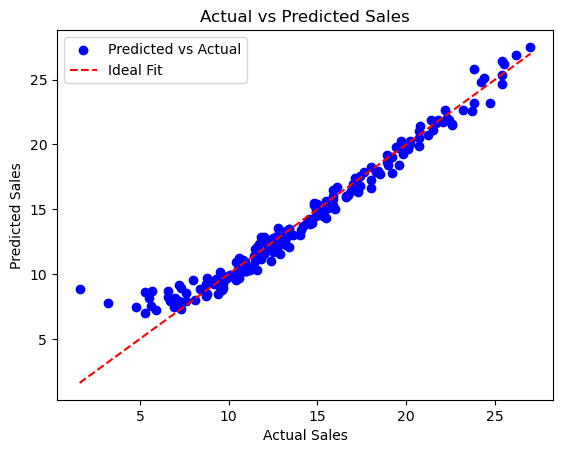

: 

In [ ]:
import matplotlib.pyplot as plt

print("The resulting prediction has a r2 score of: {}".format(r2))

plt.scatter(data["sales"], ypred, color='blue', label='Predicted vs Actual')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.plot([data["sales"].min(), data["sales"].max()],
         [data["sales"].min(), data["sales"].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()